In [236]:
#from google.colab import drive
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
from tqdm import tqdm
import torch.optim as optim
import matplotlib.pyplot as plt
import pickle
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import f1_score
import pandas

In [2]:
# Load the unzipped files, that is train and test dataset

print("Loading train and valid datasets...")

root_dir = "./A_05_Part_02_Dataset"

# Define transforms for normalization of data
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])
valid_transforms = transforms.Compose([transforms.Resize(512),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                      [0.229, 0.224, 0.225])])
       
train_data = datasets.ImageFolder(root_dir + "/Train/", transform=train_transforms)
valid_data = datasets.ImageFolder(root_dir + "/Validation/", transform=valid_transforms)

print("Loading datasets successful!")

Loading train and valid datasets...
Loading datasets successful!


In [3]:
# Verify dataset by printing lengths of train and valid sets
print(len(train_data.samples), len(valid_data.samples))

6200 628


In [4]:
# Extract classes from train data
class_names = train_data.classes
class_names

['covid-19', 'normal', 'pneumonia']

In [5]:
# Define train and test loaders
print("Defining training and valid dataset loaders...")
trainLoader = torch.utils.data.DataLoader(train_data, batch_size=10, shuffle=True)
validLoader = torch.utils.data.DataLoader(valid_data, batch_size=10, shuffle=True)
print("Done!")

Defining training and valid dataset loaders...
Done!


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


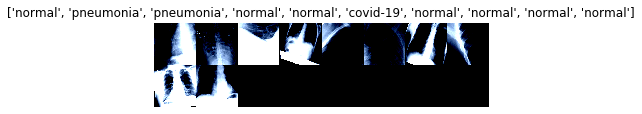

In [6]:
# Show a single or batch of images
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    plt.axis('off')
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

def show_databatch(inputs, classes):
    out = torchvision.utils.make_grid(inputs)
    imshow(out, title=[class_names[x] for x in classes])

# Get a batch of training data
inputs, classes = next(iter(trainLoader))
show_databatch(inputs, classes)

In [314]:
# Load VGG-16
print("Loading Vgg16 model...")
vgg16 = models.vgg16(pretrained=True)
print("Done!")

Loading Vgg16 model...
Done!


In [8]:
# See info about VGG16
#print(vgg16)

In [315]:
# Removing last layer of vgg 16
vgg16_numFeatures = vgg16.classifier[0].in_features # Features {no of input and output neurons in the last layer}
vgg16_features = list(vgg16.classifier.children())[:-7] # Remove FC layers
vgg16_features # Verify all features of FC layers have been removed

[]

In [10]:
# Freeze training for all layers VGG16
# for param in vgg16.features.parameters():
#     param.require_grad = False

In [316]:
# Add FC layers of your choice...
vgg16_features.extend([nn.Linear(vgg16_numFeatures, 128)])
vgg16_features.extend([nn.ReLU(inplace=True)])
vgg16_features.extend([nn.Linear(128, 64)])
vgg16_features.extend([nn.ReLU(inplace=True)])
vgg16_features.extend([nn.Linear(64, len(class_names))])
vgg16_features.extend([nn.ReLU(inplace=True)])

# Add the new layers back in the network and visualise the new network
vgg16.classifier = nn.Sequential(*vgg16_features)
vgg16.classifier

Sequential(
  (0): Linear(in_features=25088, out_features=128, bias=True)
  (1): ReLU(inplace=True)
  (2): Linear(in_features=128, out_features=64, bias=True)
  (3): ReLU(inplace=True)
  (4): Linear(in_features=64, out_features=3, bias=True)
  (5): ReLU(inplace=True)
)

In [10]:
# Focal loss defination
def FocalLoss(loss, gamma=2, alpha=0.5):
    return alpha * ((1 - torch.exp(-loss)).pow(gamma)) * loss

# One Hot encoding
def ConvertLabeslToOneHotVector(labels, totalClasses):
    ohv = np.zeros(shape=(len(labels), totalClasses))
    for i in range(len(labels)):
        ohv[i][labels[i]] = 1
    return torch.tensor(ohv)

In [29]:
# Finetune the VGG 16 NETWORK WITH BCELoss

def FineTuneVgg16(Epochs=10, networkType=vgg16, learningRate=0.001, momentum=0.9, enableFocalLoss=True):
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.SGD(networkType.parameters(), lr=learningRate, momentum=momentum)

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # switch to cuda if available
    networkType.to(device)
    networkType.train()
    vgg16loss = []

    for epoch in range(Epochs):  # loop over the dataset multiple times
        running_loss = 0.0
        pbar = tqdm(enumerate(trainLoader))
        for i, data in pbar:
            inputs, labels = data
            labels = ConvertLabeslToOneHotVector(labels=labels, totalClasses=len(class_names))
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = networkType(inputs)
            loss = criterion(outputs, labels)

            if enableFocalLoss == True:
                loss = FocalLoss(loss, gamma=2, alpha=0.5)
            
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            vgg16loss.append(loss.item())
            pbar.set_description(
                'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, i * len(inputs), len(trainLoader.dataset),
                    100. * i / len(trainLoader),
                    loss.mean()))
        
        if enableFocalLoss == True:
            torch.save(networkType.state_dict(), 'vgg16_focal_loss.pth')
        else:
            torch.save(networkType.state_dict(), 'vgg16_without_focal_loss.pth')

    print('Finished Training')
    return networkType, vgg16loss

vgg16losses = []
vgg16, vgg16losses = FineTuneVgg16(Epochs=10, networkType=vgg16, learningRate=0.001, momentum=0.9, enableFocalLoss=False)

Train Epoch: 0 [6190/6200 (100%)]	Loss: 0.568396: : 620it [07:22,  1.40it/s]
Train Epoch: 1 [6190/6200 (100%)]	Loss: 0.495321: : 620it [07:23,  1.40it/s]
Train Epoch: 2 [6190/6200 (100%)]	Loss: 0.541824: : 620it [07:22,  1.40it/s]
Train Epoch: 3 [6190/6200 (100%)]	Loss: 0.580861: : 620it [07:23,  1.40it/s]
Train Epoch: 4 [6190/6200 (100%)]	Loss: 0.520584: : 620it [07:23,  1.40it/s]
Train Epoch: 5 [6190/6200 (100%)]	Loss: 0.807979: : 620it [07:22,  1.40it/s]
Train Epoch: 6 [6190/6200 (100%)]	Loss: 0.475948: : 620it [07:23,  1.40it/s]
Train Epoch: 7 [6190/6200 (100%)]	Loss: 0.505722: : 620it [07:23,  1.40it/s]
Train Epoch: 8 [6190/6200 (100%)]	Loss: 0.546484: : 620it [07:23,  1.40it/s]
Train Epoch: 9 [6190/6200 (100%)]	Loss: 0.507244: : 620it [07:23,  1.40it/s]Finished Training



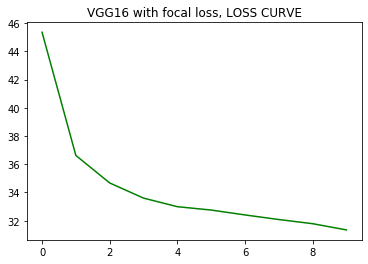

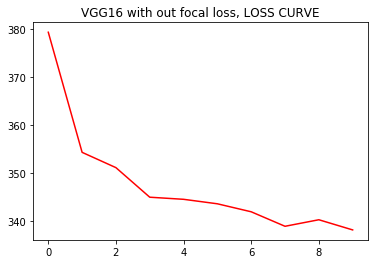

In [50]:
# VGG16 FOCAL LOSS, LOSS CURVE
def PlotVGG16LossCurve(loadLoss=True, loadFocalLossResults=True):
    avgLoss = []
    if loadLoss == True and loadFocalLossResults == True:
        avgLoss = loadModel("Vgg16_focalLoss_Avg.csv")
        avgLoss = avgLoss[0]
        title = "VGG16 with focal loss, LOSS CURVE"
        _c = "green"
    elif loadLoss == True and loadFocalLossResults == False:
        avgLoss = loadModel("Vgg16_AvgLoss.csv")
        avgLoss = avgLoss[0]
        title = "VGG16 with out focal loss, LOSS CURVE"
        _c = "red"
    elif loadLoss == False:    
        avgLoss = []
        startIndex = 0
        offset = int(len(train_data.samples) / 10)
        endIndex = offset
        for x in range(10):
            avgLoss.append(sum(vgg16losses[startIndex:endIndex]))
            startIndex = startIndex + offset
            endIndex = endIndex + offset
        title = "Avg Loss of VGG16"
        _c = "green"

    plt.title(title)
    plt.plot(range(10), list(avgLoss), color=_c)
    plt.show()

PlotVGG16LossCurve(loadLoss=True, loadFocalLossResults=True)
PlotVGG16LossCurve(loadLoss=True, loadFocalLossResults=False)

In [11]:
# Save avg loss of VGG16 WITH FOCAL LOSS as a csv for future use
def saveAvgLoss(_avgLossList, name):
    lossModel = [_avgLossList]
    pickle.dump(lossModel,open(name,'wb'))

#saveAvgLoss(avgLoss, "Vgg16_AvgLoss.csv")

In [12]:
# Load Avg Losses
def loadModel(name):
    l = pickle.load(open(name, 'rb'))
    return l

# _avgLVgg16 = loadModel("Vgg16_focalLoss_Avg.csv")
# _avgLVgg16

Accuracy of VGG16 with focal loss on validation set: 81 %


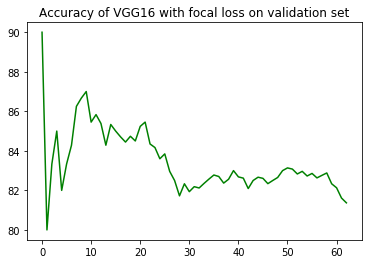

Accuracy of VGG16 with focal loss on train set: 87 %


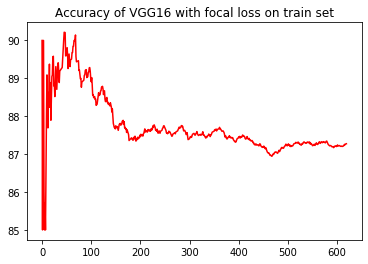

Accuracy of VGG16 with out focal loss on validation set: 88 %


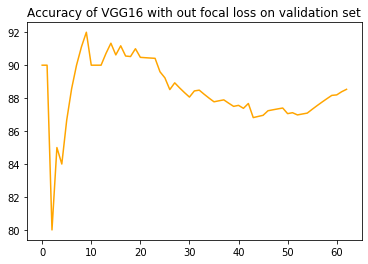

Accuracy of VGG16 with out focal loss on train set: 89 %


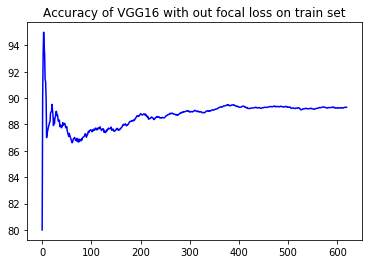

In [301]:
# Test accuracy of trained VGG16 models
def TestVGG16Accuracy(loader, focalLossModel=True, trainSet=False, validSet=True):
    if focalLossModel == True:
        vgg16.load_state_dict(torch.load("vgg16_focal_loss.pth"))
    else:
        vgg16.load_state_dict(torch.load("vgg16_without_focal_loss.pth"))
    
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # switch to cuda if available
    vgg16.to(device)
    correct = 0
    total = 0
    predictedOutputs = []
    predictedLabels = []
    _accuracy = []
    with torch.no_grad():
        for data in loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = vgg16(images)
            _, predicted = torch.max(outputs.data, 1)
            predictedOutputs.append(predicted)
            predictedLabels.append(labels)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            _accuracy.append(100 * correct / total)

    if focalLossModel == True:
        if trainSet == True:
            print('Accuracy of VGG16 with focal loss on train set: %d %%' % (100 * correct / total))
            plt.title("Accuracy of VGG16 with focal loss on train set")
            _c = "red"
        if validSet == True:
            print('Accuracy of VGG16 with focal loss on validation set: %d %%' % (100 * correct / total))
            plt.title("Accuracy of VGG16 with focal loss on validation set")
            _c = "green"
    else:
        if trainSet == True:
            print('Accuracy of VGG16 with out focal loss on train set: %d %%' % (100 * correct / total))
            plt.title("Accuracy of VGG16 with out focal loss on train set")
            _c = "blue"   
        if validSet == True:
            print('Accuracy of VGG16 with out focal loss on validation set: %d %%' % (100 * correct / total))
            plt.title("Accuracy of VGG16 with out focal loss on validation set")
            _c = "orange"

    plt.plot(_accuracy, color=_c)
    plt.show()
    return predictedOutputs, predictedLabels, _accuracy

P1, L1, vggA1 = TestVGG16Accuracy(validLoader, focalLossModel=True, trainSet=False, validSet=True)
P2, L2, vggA2 = TestVGG16Accuracy(trainLoader, focalLossModel=True, trainSet=True, validSet=False)
P3, L3, vggA3 = TestVGG16Accuracy(validLoader, focalLossModel=False, trainSet=False, validSet=True)
P4, L4, vggA4 = TestVGG16Accuracy(trainLoader, focalLossModel=False, trainSet=True, validSet=False)

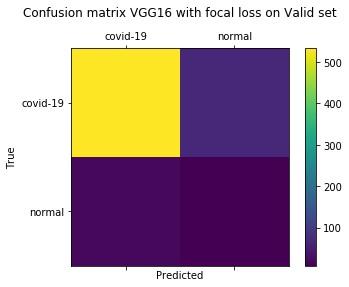

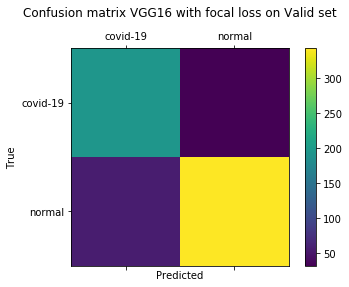

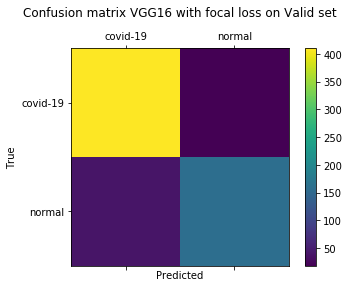

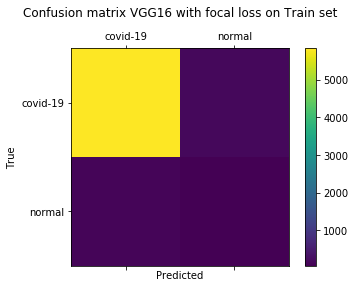

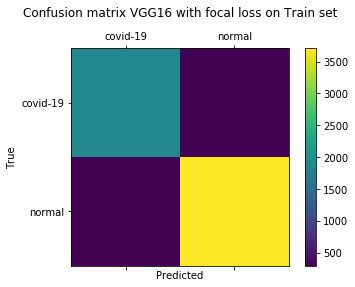

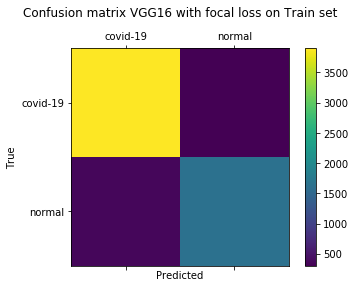

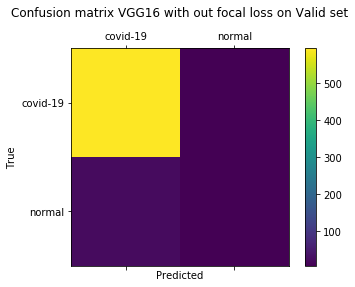

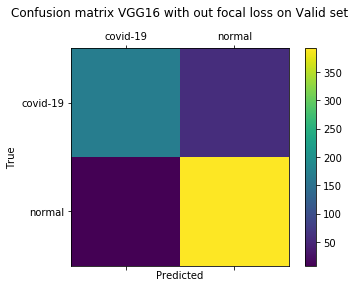

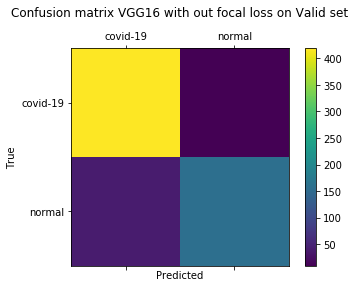

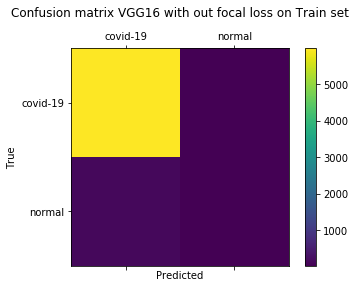

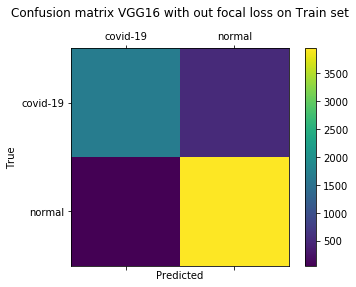

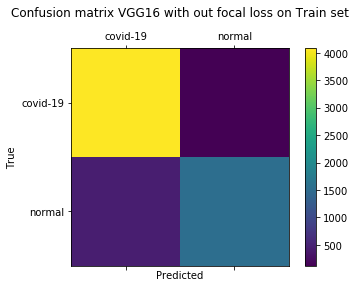

In [302]:
def PlotConfusionMatrixForVGG16(pY, tY, title):
    predY = []
    trueY = []
    
    pY = [i.cpu().numpy() for i in pY]
    tY = [i.cpu().numpy() for i in tY]
    
    for i in range(len(pY)):
        for j in range(len(pY[i])):
            predY.append(pY[i][j])

    for i in range(len(tY)):
        for j in range(len(tY[i])):
            trueY.append(tY[i][j])

    cf = multilabel_confusion_matrix(trueY, predY, labels=[0, 1, 2])
    for i in range(len(cf)):
        fig = plt.figure()
        ax = fig.add_subplot(111)
        cax = ax.matshow(cf[i])
        plt.title(title)
        fig.colorbar(cax)
        ax.set_xticklabels([''] + class_names)
        ax.set_yticklabels([''] + class_names)
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.show()

PlotConfusionMatrixForVGG16(P1, L1, "Confusion matrix VGG16 with focal loss on Valid set\n")
PlotConfusionMatrixForVGG16(P2, L2, "Confusion matrix VGG16 with focal loss on Train set\n")
PlotConfusionMatrixForVGG16(P3, L3, "Confusion matrix VGG16 with out focal loss on Valid set\n")
PlotConfusionMatrixForVGG16(P4, L4, "Confusion matrix VGG16 with out focal loss on Train set\n")


In [270]:
#PlotConfusionMatrixForVGG16(P1, L1, "Confusion matrix VGG16 with focal loss on Valid set\n")

In [304]:
# F1 scores for VGG 16
def PredictF1Score(pY, tY):
    predY = []
    trueY = []

    pY = [i.cpu().numpy() for i in pY]
    tY = [i.cpu().numpy() for i in tY]

    for i in range(len(pY)):
        for j in range(len(pY[i])):
            predY.append(pY[i][j])

    for i in range(len(tY)):
        for j in range(len(tY[i])):
            trueY.append(tY[i][j])
    
    return f1_score(trueY, predY, average='macro')

print("F1 score VGG16 with focal loss on Valid set: ", PredictF1Score(P1, L1))
print("F1 score VGG16 with focal loss on Train set: ", PredictF1Score(P2, L2))
print("F1 score VGG16 with out focal loss on Valid set: ", PredictF1Score(P3, L3))
print("F1 score VGG16 with out focal loss on Train set: ", PredictF1Score(P4, L4))

F1 score VGG16 with focal loss on Valid set:  0.6290206475695567
F1 score VGG16 with focal loss on Train set:  0.6781604010946346
F1 score VGG16 with out focal loss on Valid set:  0.6832137568986404
F1 score VGG16 with out focal loss on Train set:  0.6981291843401226


In [317]:
# Load RESNET-18
resnet18 = models.resnet18(pretrained=True)

In [318]:
# # Removing last layer of resnet 18
num_features_resnet = resnet18.fc.in_features
featuresResnet = list(resnet18.fc.children())[:-1] # Remove last layer
featuresResnet

[]

In [15]:
# # Freeze the layers of resnet 18 if any
# for param in resnet18.fc.parameters():# features.parameters():
#     param.require_grad = True

In [319]:
# Add 2 fully connectd layers to Resnet 18

featuresResnet.extend([nn.Linear(num_features_resnet, 210)]) #[(11*10) + 100]
featuresResnet.extend([nn.Linear(210, len(class_names))])

# Add the new layers back in the network
resnet18.fc = nn.Sequential(*featuresResnet)
resnet18.fc

Sequential(
  (0): Linear(in_features=512, out_features=210, bias=True)
  (1): Linear(in_features=210, out_features=3, bias=True)
)

In [33]:
# Finetune the RESNET 18 NETWORK WITH BCELoss
def FineTuneResnet18(Epochs=10, networkType=resnet18, learningRate=0.001, momentum=0.9, enableFocalLoss=True):
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.SGD(networkType.parameters(), lr=learningRate, momentum=momentum)

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # switch to cuda if available
    networkType.to(device)
    networkType.train()
    resnet18Loss = []

    for epoch in range(Epochs):  # loop over the dataset multiple times
        running_loss = 0.0
        pbar = tqdm(enumerate(trainLoader))
        for i, data in pbar:
            inputs, labels = data
            labels = ConvertLabeslToOneHotVector(labels=labels, totalClasses=len(class_names))
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = networkType(inputs)
            loss = criterion(outputs, labels)

            if enableFocalLoss == True:
                loss = FocalLoss(loss, gamma=2, alpha=0.5)
            
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            resnet18Loss.append(loss.item())
            pbar.set_description(
                'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, i * len(inputs), len(trainLoader.dataset),
                    100. * i / len(trainLoader),
                    loss.item()))
        
        if enableFocalLoss == True:
            torch.save(networkType.state_dict(), 'resnet18_focal_loss.pth')
        else:
            torch.save(networkType.state_dict(), 'resnet18_without_focal_loss.pth')

    print('Finished Training')
    return networkType, resnet18Loss

resnet18losses = []
resnet18, resnet18losses = FineTuneResnet18(Epochs=10, networkType=resnet18, learningRate=0.001, momentum=0.9, enableFocalLoss=False)

Train Epoch: 0 [6190/6200 (100%)]	Loss: 0.146129: : 620it [04:33,  2.27it/s]
Train Epoch: 1 [6190/6200 (100%)]	Loss: 0.229848: : 620it [04:38,  2.23it/s]
Train Epoch: 2 [6190/6200 (100%)]	Loss: 0.127098: : 620it [04:35,  2.25it/s]
Train Epoch: 3 [6190/6200 (100%)]	Loss: 0.113750: : 620it [04:35,  2.25it/s]
Train Epoch: 4 [6190/6200 (100%)]	Loss: 0.189421: : 620it [04:36,  2.24it/s]
Train Epoch: 5 [6190/6200 (100%)]	Loss: 0.190848: : 620it [04:37,  2.24it/s]
Train Epoch: 6 [6190/6200 (100%)]	Loss: 0.186732: : 620it [04:39,  2.22it/s]
Train Epoch: 7 [6190/6200 (100%)]	Loss: 0.228635: : 620it [04:38,  2.22it/s]
Train Epoch: 8 [6190/6200 (100%)]	Loss: 0.355004: : 620it [04:39,  2.22it/s]
Train Epoch: 9 [6190/6200 (100%)]	Loss: 0.061288: : 620it [04:40,  2.21it/s]Finished Training



Accuracy of RESNET18 with focal loss on validation set: 85 %


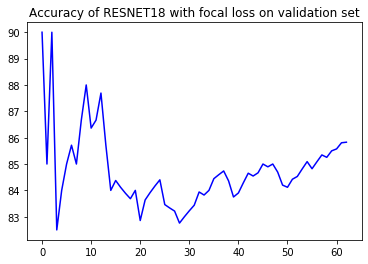



Accuracy of RESNET18 with focal loss on train set: 86 %


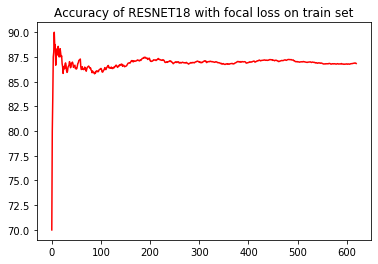



Accuracy of RESNET18 with out focal loss on validation set: 89 %


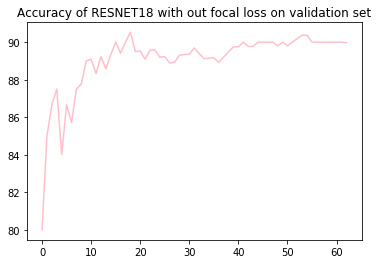



Accuracy of RESNET18 with out focal loss on train set: 89 %


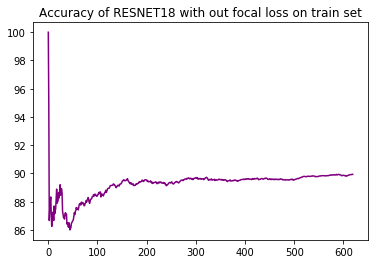

In [308]:
# Test accuracy of trained VGG16 models
def TestRESNET18Accuracy(loader, focalLossModel=True, trainSet=False, validSet=True):
    if focalLossModel == True:
        resnet18.load_state_dict(torch.load("resnet18_focal_loss.pth"))
    else:
        resnet18.load_state_dict(torch.load("resnet18_without_focal_loss.pth"))
    
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # switch to cuda if available
    resnet18.to(device)
    correct = 0
    total = 0
    predictedOutputs = []
    predictedLabels = []
    _accuracy = []

    with torch.no_grad():
        for data in loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = resnet18(images)
            _, predicted = torch.max(outputs.data, 1)
            predictedOutputs.append(predicted)
            predictedLabels.append(labels)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            _accuracy.append(100 * correct / total)

    if focalLossModel == True:
        if trainSet == True:
            print('Accuracy of RESNET18 with focal loss on train set: %d %%' % (100 * correct / total))
            plt.title("Accuracy of RESNET18 with focal loss on train set")
            _c = "red"
        if validSet == True:
            print('Accuracy of RESNET18 with focal loss on validation set: %d %%' % (100 * correct / total))
            plt.title("Accuracy of RESNET18 with focal loss on validation set")
            _c = "blue"
    else:
        if trainSet == True:
            print('Accuracy of RESNET18 with out focal loss on train set: %d %%' % (100 * correct / total))
            plt.title("Accuracy of RESNET18 with out focal loss on train set")
            _c = "purple"
        if validSet == True:
            print('Accuracy of RESNET18 with out focal loss on validation set: %d %%' % (100 * correct / total))
            plt.title("Accuracy of RESNET18 with out focal loss on validation set")
            _c = "pink"
    
    plt.plot(_accuracy, color=_c)
    plt.show()
    print("\n")
    return predictedOutputs, predictedLabels, _accuracy


yTest1, yTrue1, rsA1 = TestRESNET18Accuracy(validLoader, focalLossModel=True, trainSet=False, validSet=True)
yTest2, yTrue2, rsA2 = TestRESNET18Accuracy(trainLoader, focalLossModel=True, trainSet=True, validSet=False)
yTest3, yTrue3, rsA3 = TestRESNET18Accuracy(validLoader, focalLossModel=False, trainSet=False, validSet=True)
yTest4, yTrue4, rsA4 = TestRESNET18Accuracy(trainLoader, focalLossModel=False, trainSet=True, validSet=False)

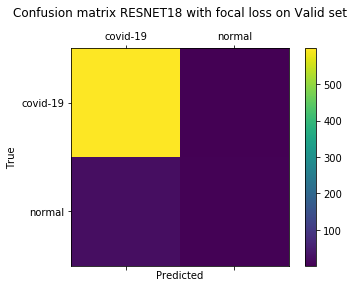

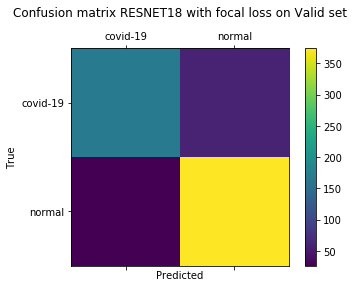

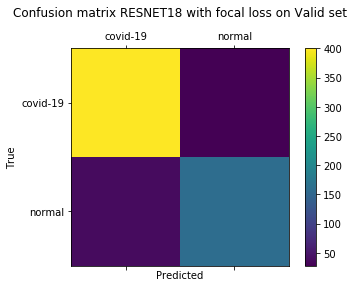

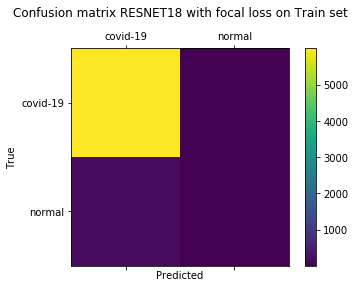

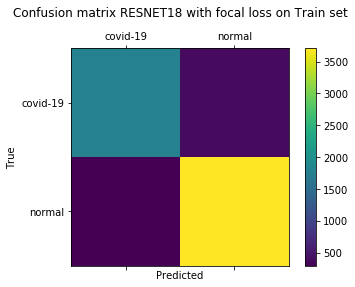

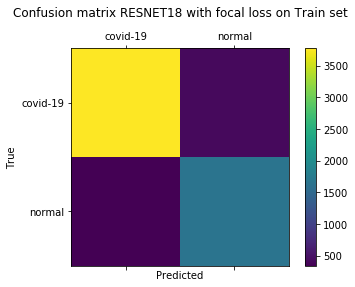

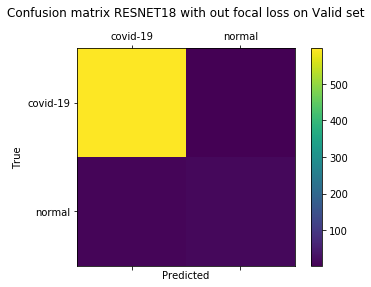

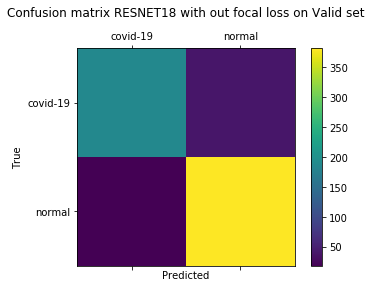

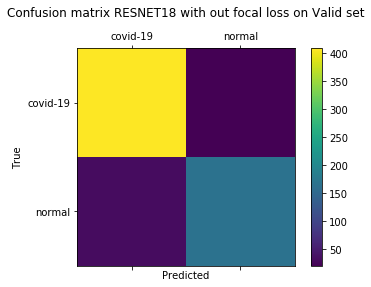

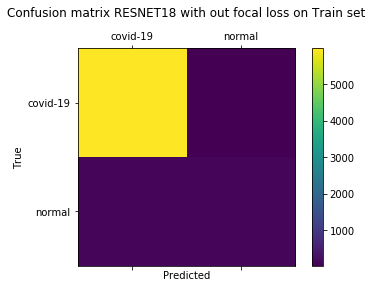

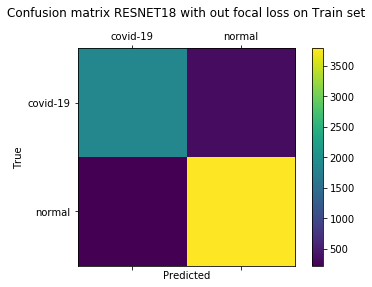

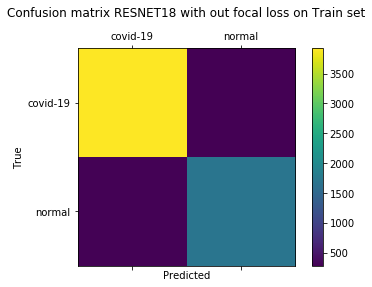

In [309]:
def PlotConfusionMatrixForRESNET18(pY, tY, title):
    predY = []
    trueY = []
    
    pY = [i.cpu().numpy() for i in pY]
    tY = [i.cpu().numpy() for i in tY]
    
    for i in range(len(pY)):
        for j in range(len(pY[i])):
            predY.append(pY[i][j])

    for i in range(len(tY)):
        for j in range(len(tY[i])):
            trueY.append(tY[i][j])

    cf = multilabel_confusion_matrix(trueY, predY, labels=[0, 1, 2])
    for i in range(len(cf)):
        fig = plt.figure()
        ax = fig.add_subplot(111)
        cax = ax.matshow(cf[i])
        plt.title(title)
        fig.colorbar(cax)
        ax.set_xticklabels([''] + class_names)
        ax.set_yticklabels([''] + class_names)
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.show()

PlotConfusionMatrixForRESNET18(yTest1, yTrue1, "Confusion matrix RESNET18 with focal loss on Valid set\n")
PlotConfusionMatrixForRESNET18(yTest2, yTrue2, "Confusion matrix RESNET18 with focal loss on Train set\n")
PlotConfusionMatrixForRESNET18(yTest3, yTrue3, "Confusion matrix RESNET18 with out focal loss on Valid set\n")
PlotConfusionMatrixForRESNET18(yTest4, yTrue4, "Confusion matrix RESNET18 with out focal loss on Train set\n")

In [140]:
# F1 scores for RESNET 18
print("F1 score RESNET18 with focal loss on Valid set: ", PredictF1Score(yTest1, yTrue1))
print("F1 score RESNET18 with focal loss on Train set: ", PredictF1Score(yTest2, yTrue2))
print("F1 score RESNET18 with out focal loss on Valid set: ", PredictF1Score(yTest3, yTrue3))
print("F1 score VRESNET18GG16 with out focal loss on Train set: ", PredictF1Score(yTest4, yTrue4))

F1 score RESNET18 with focal loss on Valid set:  0.670458337677152
F1 score RESNET18 with focal loss on Train set:  0.6277579087636159
F1 score RESNET18 with out focal loss on Valid set:  0.8339832218309273
F1 score VRESNET18GG16 with out focal loss on Train set:  0.8055614678336286


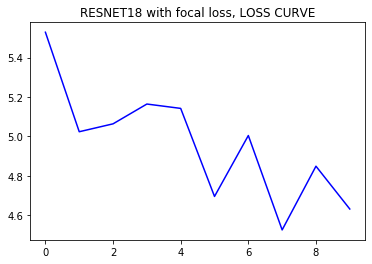

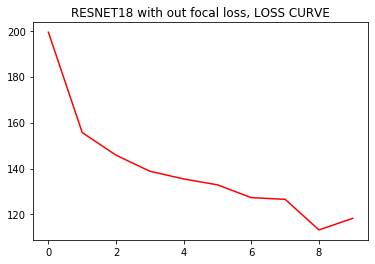

In [38]:
# RESNET18 FOCAL LOSS, LOSS CURVE
def PlotResnet18LossCurve(loadLoss=True, loadFocalLossResults=True):
    avgLoss = []
    if loadLoss == True and loadFocalLossResults == True:
        avgLoss = loadModel("Resnet18_FocalLoss_AvgLoss.csv")
        avgLoss = avgLoss[0]
        title = "RESNET18 with focal loss, LOSS CURVE"
        _c = "blue"
    elif loadLoss == True and loadFocalLossResults == False:
        avgLoss = loadModel("Resnet18_Without_FocalLoss_AvgLoss.csv")
        avgLoss = avgLoss[0]
        title = "RESNET18 with out focal loss, LOSS CURVE"
        _c = "red"
    elif loadLoss == False:    
        avgLoss = []
        startIndex = 0
        offset = int(len(train_data.samples) / 10)
        endIndex = offset
        for x in range(10):
            avgLoss.append(sum(resnet18losses[startIndex:endIndex]))
            startIndex = startIndex + offset
            endIndex = endIndex + offset
        title = "Avg Loss of RESNET18"
        _c = "green"

    plt.title(title)
    plt.plot(range(10), list(avgLoss), color=_c)
    plt.show()

    if loadLoss == False:
        return avgLoss

# resnet18AvgLoss = PlotResnet18LossCurve(loadLoss=False, loadFocalLossResults=False)
PlotResnet18LossCurve(loadLoss=True, loadFocalLossResults=True)
PlotResnet18LossCurve(loadLoss=True, loadFocalLossResults=False)

In [36]:
# resnet18AvgLoss
# saveAvgLoss(resnet18AvgLoss, "Resnet18_Without_FocalLoss_AvgLoss.csv")

In [ ]:
# Confusion matrix for the valid model VGG16 with focal loss
vgg16.load_state_dict(torch.load("vgg16_focal_loss.pth"))
confusion_matrix(y_true, y_pred, labels=["ant", "bird", "cat"])

In [310]:
# TEST SET RESULTS
test_transforms = transforms.Compose([transforms.Resize(512),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                      [0.229, 0.224, 0.225])])

test_data = datasets.ImageFolder(root_dir + "/Test/", transform=test_transforms)
testLoader = torch.utils.data.DataLoader(test_data, batch_size=10, shuffle=True)

fileNames = test_data.samples
fileNames = list(fileNames)

In [311]:
_fileNames = []
for i in range(len(fileNames)):
    a = fileNames[i][0].split("\\")
    _fileNames.append(a[1])

In [312]:
resnet18.load_state_dict(torch.load("resnet18_without_focal_loss.pth"))
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # switch to cuda if available
resnet18.to(device)
csvList = []
threshold = 0.55
fileNameIndex = 0
with torch.no_grad():
    for data in testLoader:
        images, _= data
        images = images.to(device)
        outputs = resnet18(images)
        outputs = torch.nn.functional.sigmoid(outputs)
        for x in range(len(outputs)):

            if outputs[x][0] > threshold:
                covidLabel = 1
            else:
                covidLabel = 0

            if outputs[x][1] > threshold:
                normalLabel = 1
            else:
                normalLabel = 0

            if outputs[x][2] > threshold:
                pneumoniaLabel = 1
            else:
                pneumoniaLabel = 0
            
            tempEntry = []
            tempEntry.append(_fileNames[fileNameIndex])
            tempEntry.append(covidLabel)
            tempEntry.append(pneumoniaLabel)
            tempEntry.append(normalLabel)
            csvList.append(tempEntry)
            fileNameIndex = fileNameIndex + 1

In [313]:
df = pandas.DataFrame(csvList)
df.to_csv("MSCS18011_Results.csv", index=False, header=False)